![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Importación librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import product

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

#from xgboost import XGBRegressor, DMatrix
import xgboost as xgb

In [2]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [3]:
# Visualización datos de entrenamiento
print(dataTraining.info())
dataTraining.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    400000 non-null  int64 
 1   Year     400000 non-null  int64 
 2   Mileage  400000 non-null  int64 
 3   State    400000 non-null  object
 4   Make     400000 non-null  object
 5   Model    400000 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB
None


,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [4]:
# Visualización datos de test
print(dataTesting.info())
dataTesting.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Year     100000 non-null  int64 
 1   Mileage  100000 non-null  int64 
 2   State    100000 non-null  object
 3   Make     100000 non-null  object
 4   Model    100000 non-null  object
dtypes: int64(2), object(3)
memory usage: 4.6+ MB
None


,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


In [5]:
def grafica_distribucion(df: pd.DataFrame):
    '''
    '''
    df_num = df.select_dtypes(exclude=[object]).copy()
    df_cat = df.select_dtypes(include=[object]).copy()

    var_num = df_num.columns.to_list()
    col = len(var_num)
    fig, axes = plt.subplots (1,col,figsize = (18,4))
    fig.suptitle('DISTRIBUCIÓN DE VARIABLES NUMERICAS')

    for i,j in enumerate (var_num):
        data = df_num[j]
        axes[i].hist(data,bins = 50,color = "green",alpha = 0.65, rwidth = 0.85);
        axes[i].set_xlabel(f'{j}')
        axes[1].set_ylabel('cantidad')
    
    sns.pairplot(df);
    

    var_cat= df_cat.columns.to_list()
    col = len(var_cat)
    fig, axes = plt.subplots (col,1,figsize = (17,7))
    fig.suptitle('DISTRIBUCIÓN DE VARIABLES CATAGÓRICAS')

    for i, j in enumerate(var_cat):
        data = df_cat[j].value_counts()
        sns.countplot(x=j, data=df_cat, ax=axes[i]);
        axes[i].set_xlabel(f'{j}')
        axes[i].set_ylabel('cantidad')
        axes[i].tick_params(axis='x', rotation=45,labelsize=7)

    return

def stats(df:pd.DataFrame):
    '''
    '''
    df_num = df.select_dtypes(exclude=[object]).copy()
    df_cat = df.select_dtypes(include=[object]).copy()

    for i,j in enumerate (df_cat.columns.tolist()):
        print(f'Variable: {j}')
        print(f'Cantidad de clases: {df_cat[j].nunique()}')
        print(f'Top 10 de las clases: {Counter(df_cat[j]).most_common(10)}')
        print('------------------------------------')
        
    return df_num.describe().T 

def remover(df, columns, threshold=3):
    '''
    '''
    df_no_outliers = pd.DataFrame()
    
    for column in columns:
        z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
        df_filtered = df[z_scores <= threshold]
        df_no_outliers = pd.concat([df_no_outliers, df_filtered], ignore_index=True)
    
    return df_no_outliers

def metrics(test,predd):
      RMSE = np.sqrt(mean_squared_error(test,predd))
      return print(f"La métrica de evaluación del modelo regresión es:\nRMSE : {RMSE:,.6f}")

def metrics_CV(model,X,y):
      mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
      mean_mse = -np.mean(mse_scores)
      RMSE = np.sqrt(mean_mse)
      return RMSE

In [6]:
stats(dataTraining)

Variable: State
Cantidad de clases: 51
Top 10 de las clases: [(' TX', 45918), (' CA', 36534), (' FL', 33759), (' GA', 18182), (' NC', 17930), (' IL', 16793), (' VA', 15894), (' PA', 13039), (' NY', 12447), (' NJ', 12132)]
------------------------------------
Variable: Make
Cantidad de clases: 38
Top 10 de las clases: [('Ford', 62899), ('Chevrolet', 58383), ('Toyota', 45941), ('Honda', 33191), ('Jeep', 24369), ('GMC', 20834), ('Kia', 16352), ('Dodge', 16159), ('Hyundai', 15057), ('Lexus', 13664)]
------------------------------------
Variable: Model
Cantidad de clases: 525
Top 10 de las clases: [('Silverado', 18085), ('Grand', 12344), ('Sierra', 8409), ('Accord', 7357), ('F-1504WD', 6684), ('Wrangler', 5914), ('Civic', 5766), ('3', 5516), ('Jetta', 5131), ('FusionSE', 4986)]
------------------------------------


,count,mean,std,min,25%,50%,75%,max
Price,400000.0,21146.919312,10753.664940,5001.0,13499.0,18450.0,26999.0,79999.0
Year,400000.0,2013.198125,3.292326,1997.0,2012.0,2014.0,2016.0,2018.0
Mileage,400000.0,55072.956895,40881.018845,5.0,25841.0,42955.0,77433.0,2457832.0


In [7]:
dataTraining['Make'].value_counts()

Make
Ford             62899
Chevrolet        58383
Toyota           45941
Honda            33191
Jeep             24369
GMC              20834
Kia              16352
Dodge            16159
Hyundai          15057
Lexus            13664
BMW              12326
Volkswagen       11110
Nissan           10569
Chrysler          9046
Mercedes-Benz     7575
Subaru            6791
Cadillac          5414
Buick             4842
Ram               3611
MINI              2766
Land              2713
INFINITI          2406
Acura             2403
Mazda             2332
Lincoln           1786
Volvo             1710
Audi              1423
Mitsubishi        1272
Porsche            980
Scion              651
Jaguar             324
Pontiac            308
FIAT               272
Mercury            271
Tesla              148
Bentley             57
Suzuki              38
Freightliner         7
Name: count, dtype: int64

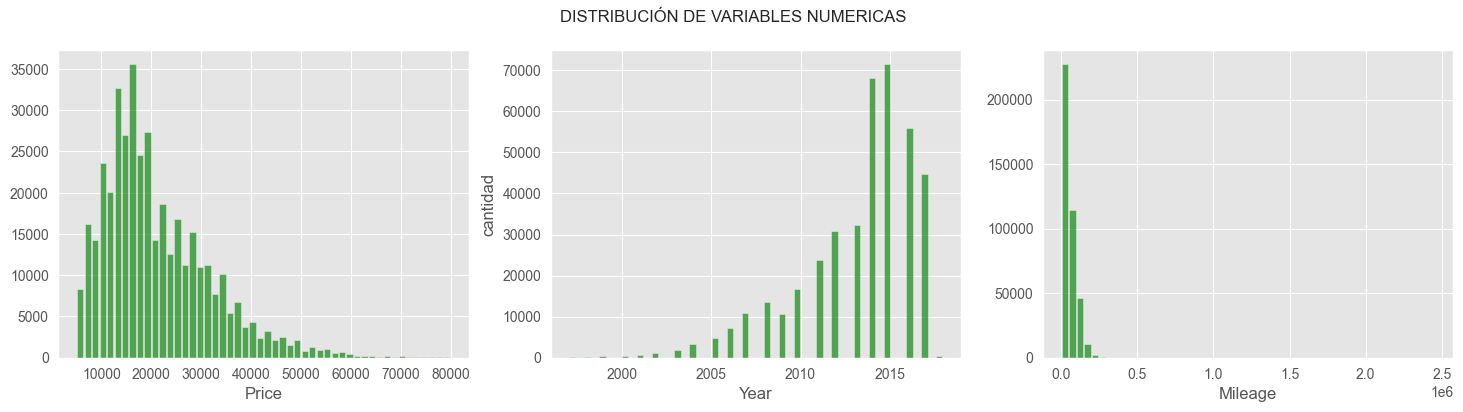

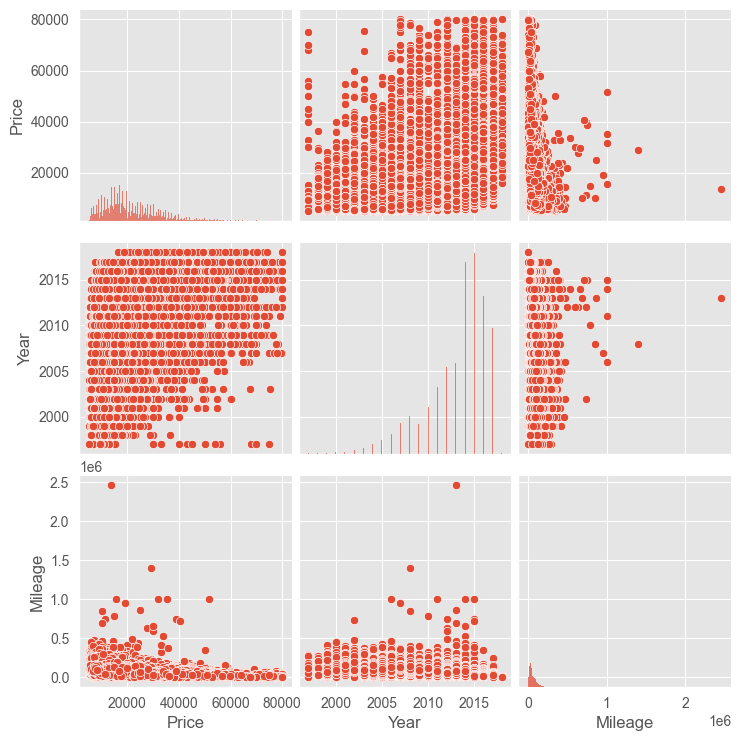

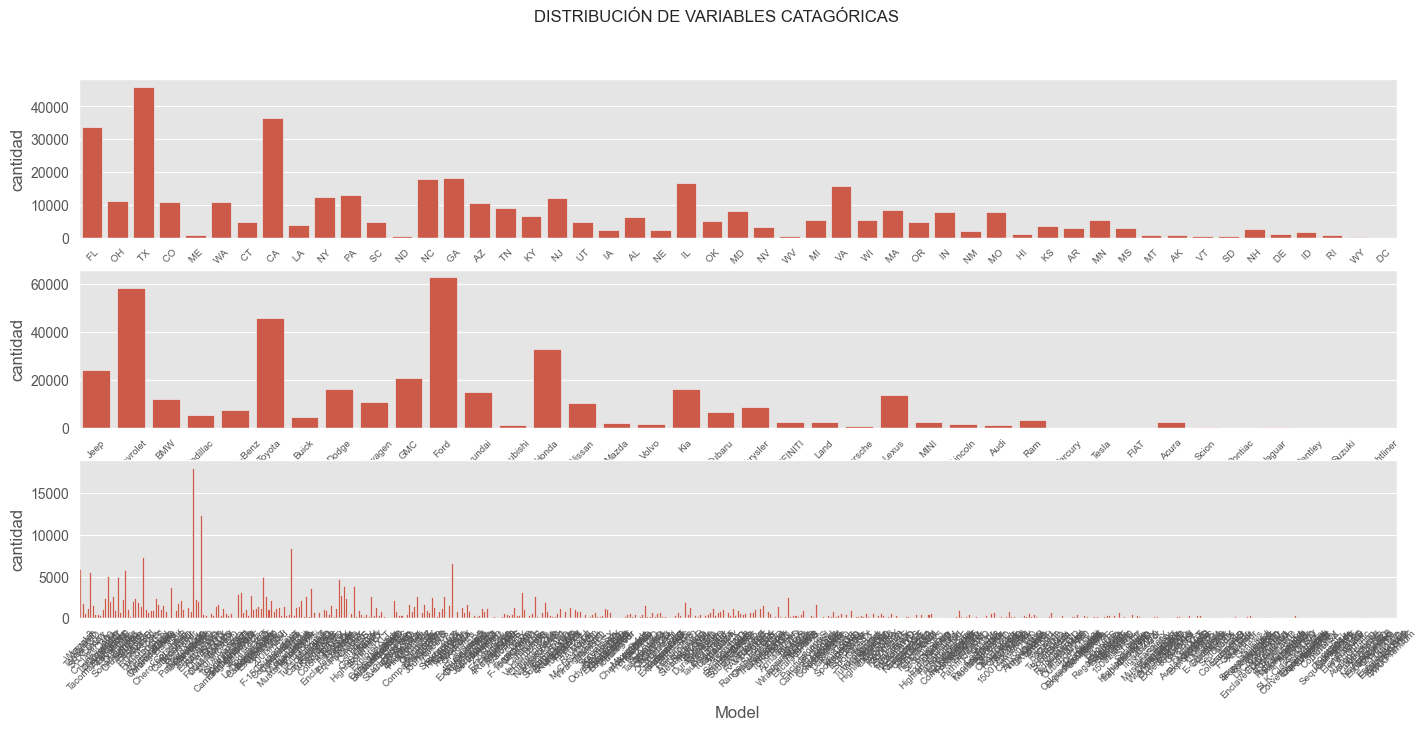

In [8]:
grafica_distribucion(dataTraining)

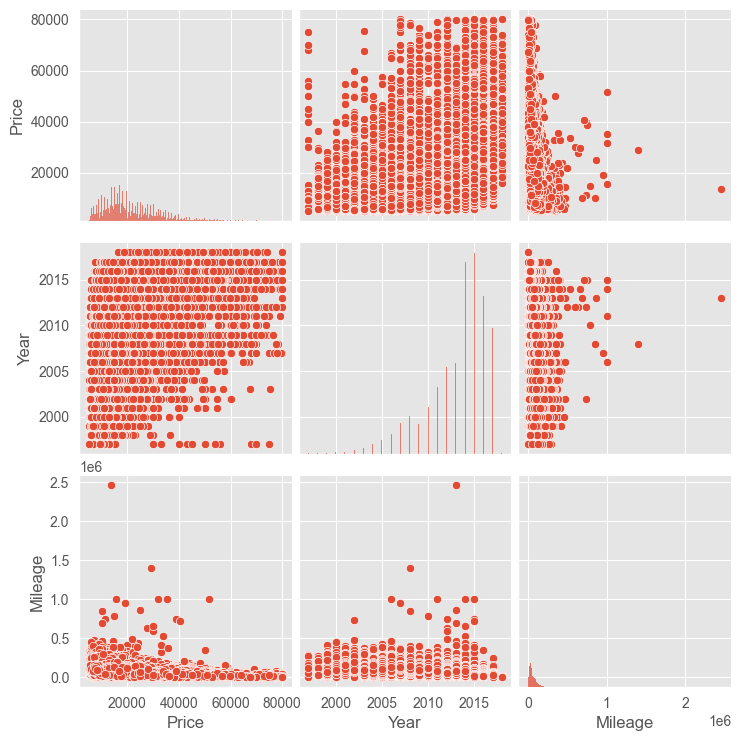

In [9]:
dataTraining_ = remover(dataTraining, ['Mileage'], threshold=100)
dataTraining_['Make-Model'] = dataTraining_['Make'] + '-' + dataTraining_['Model']
dataTraining_.drop(columns=['Make', 'Model'], inplace=True)
sns.pairplot(dataTraining_);

In [10]:
X = dataTraining_.drop(['Price'], axis=1)
y = dataTraining_['Price']

data_num = X.select_dtypes(exclude=[object]).copy()
data_cat = X.select_dtypes(include=[object]).copy()

scaler = StandardScaler()
data_num_scaled = scaler.fit_transform(data_num)

decomposer = PCA(n_components=2).fit(data_num_scaled)
data_num_pca = decomposer.transform(data_num_scaled)

for i in data_cat.columns:
    data_cat[i] = data_cat[i].astype('category')

data_cat_encoded = pd.get_dummies(data_cat,columns=data_cat.columns, drop_first=True)

X_training = np.concatenate((data_num_pca, data_cat_encoded), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_training, y, test_size=0.20, random_state=42)

X_train = pd.DataFrame(X_train, columns=['PCA1', 'PCA2'] + data_cat_encoded.columns.tolist())
X_test = pd.DataFrame(X_test, columns=['PCA1', 'PCA2'] + data_cat_encoded.columns.tolist())

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

(320000, 587) (80000, 587) (320000,) (80000,)


In [ ]:
range_learning = [float(x) for x in np.linspace(0.1, 1.0, 100)]
RMSE_scores = []

for learning in range_learning:

    params = {
        'objective':'reg:squarederror',
        'eval_metric':'rmse',
        'random_state':42,
        'n_jobs':-1,
        'booster':'gbtree',
        'learning_rate':learning
        }

    model_xgb = xgb.train(params, dtrain, num_boost_round=500,early_stopping_rounds=10, evals=[(dtest, 'test')], verbose_eval=False)
    prediction = model_xgb.predict(dtest)
    RMSE_scores.append(np.sqrt(mean_squared_error(y_test, prediction)))

learning = range_learning[np.argmin(RMSE_scores)]
print(f'El valor óptimo es: {learning}')

In [ ]:
range_depth = [int(x) for x in np.linspace(1,15,15)]
RMSE_scores = []


for depth in range_depth:
    
    params = {
        'objective':'reg:squarederror',
        'eval_metric':'rmse',
        'random_state':42,
        'n_jobs':-1,
        'booster':'gbtree',
        'learning_rate':learning,
        'max_depth': depth
    }

    model_xgb = xgb.train(params, dtrain, num_boost_round=300,early_stopping_rounds=10, evals=[(dtest, 'test')], verbose_eval=False)
    prediction = model_xgb.predict(dtest)
    RMSE_scores.append(np.sqrt(mean_squared_error(y_test, prediction)))

depth = range_depth[np.argmin(RMSE_scores)]
print(f'El valor óptimo es: {depth}')

In [ ]:
range_leaves = [int(x) for x in np.linspace(1, 50, 50)]
RMSE_scores = []

for leaves in range_leaves:
        
    params = {
        'objective':'reg:squarederror',
        'eval_metric':'rmse',
        'random_state':42,
        'n_jobs':-1,
        'booster':'gbtree',
        'learning_rate':learning,
        'max_depth': depth,
        'max_leaves': leaves
        }

    model_xgb = xgb.train(params, dtrain, num_boost_round=300,early_stopping_rounds=10, evals=[(dtest, 'test')], verbose_eval=False)
    prediction = model_xgb.predict(dtest)
    RMSE_scores.append(np.sqrt(mean_squared_error(y_test, prediction)))

leaves = range_leaves[np.argmin(RMSE_scores)]
print(f'El valor óptimo es: {leaves}')

In [ ]:
range_subsample = [float(x) for x in np.linspace(0.5, 1.0, 25)]
RMSE_scores = []

for subsample in range_subsample:

    params = {
        'objective':'reg:squarederror',
        'eval_metric':'rmse',
        'random_state':42,
        'n_jobs':-1,
        'booster':'gbtree',
        'learning_rate':learning,
        'max_depth': depth,
        'max_leaves': leaves,
        'subsample': subsample
        }

    model_xgb = xgb.train(params, dtrain, num_boost_round=300,early_stopping_rounds=10, evals=[(dtest, 'test')], verbose_eval=False)
    prediction = model_xgb.predict(dtest)
    RMSE_scores.append(np.sqrt(mean_squared_error(y_test, prediction)))

subsample = range_subsample[np.argmin(RMSE_scores)]
print(f'El valor óptimo es: {subsample}')

In [ ]:
range_colsample = [float(x) for x in np.linspace(0.5, 1.0, 25)]
RMSE_scores = []

for colsample in range_colsample:

    params = {
        'objective':'reg:squarederror',
        'eval_metric':'rmse',
        'random_state':42,
        'n_jobs':-1,
        'booster':'gbtree',
        'learning_rate':learning,
        'max_depth': depth,
        'max_leaves': leaves,
        'subsample': subsample,
        'colsample_bytree': colsample
        }
    
    model_xgb = xgb.train(params, dtrain, num_boost_round=300,early_stopping_rounds=10, evals=[(dtest, 'test')], verbose_eval=False)
    prediction = model_xgb.predict(dtest)
    RMSE_scores.append(np.sqrt(mean_squared_error(y_test, prediction)))

colsample = range_colsample[np.argmin(RMSE_scores)]
print(f'El valor óptimo es: {colsample}')

In [ ]:
range_gamma= [float(x) for x in np.linspace(0, 1.0, 50)]
RMSE_scores = [] 

for gamma_ in range_gamma:

    params = {
        'objective':'reg:squarederror',
        'eval_metric':'rmse',
        'random_state':42,
        'n_jobs':-1,
        'booster':'gbtree',
        'learning_rate':learning,
        'max_depth': depth,
        'max_leaves': leaves,
        'subsample': subsample,
        'colsample_bytree': colsample,
        'gamma': gamma_
        }
    
    model_xgb = xgb.train(params, dtrain, num_boost_round=300,early_stopping_rounds=10, evals=[(dtest, 'test')], verbose_eval=False)
    prediction = model_xgb.predict(dtest)
    RMSE_scores.append(np.sqrt(mean_squared_error(y_test, prediction)))

gamma_ = range_gamma[np.argmin(RMSE_scores)]
print(f'El valor óptimo es: {gamma_}')

In [ ]:
range_regularization = [float(x) for x in np.linspace(0, 5, 100)]
RMSE_scores = []

for regul in range_regularization:

    params = {
        'objective':'reg:squarederror',
        'eval_metric':'rmse',
        'random_state':42,
        'n_jobs':-1,
        'booster':'gbtree',
        'learning_rate':learning,
        'max_depth': depth,
        'max_leaves': leaves,
        'subsample': subsample,
        'colsample_bytree': colsample,
        'gamma': gamma_,
        'reg_lambda': regul
        }
    
    model_xgb = xgb.train(params, dtrain, num_boost_round=300,early_stopping_rounds=10, evals=[(dtest, 'test')], verbose_eval=False)
    prediction = model_xgb.predict(dtest)
    RMSE_scores.append(np.sqrt(mean_squared_error(y_test, prediction)))

regul = range_regularization[np.argmin(RMSE_scores)]
print(f'El valor óptimo es: {regul}')

In [11]:
params = {
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'random_state':42,
    'n_jobs':-1,
    'booster':'gbtree',
    'learning_rate':0.6,
    'max_depth': 6,
    'max_leaves': 43,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_lambda': 2.0707070707070705
    }

model_xgb = xgb.train(params, dtrain, num_boost_round=300,early_stopping_rounds=10, evals=[(dtest, 'test')], verbose_eval=False)
prediction = model_xgb.predict(dtest)

metrics(y_test, prediction)


La métrica de evaluación del modelo regresión es:
RMSE : 3,506.816728


params = {
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'random_state':42,
    'n_jobs':-1,
    'booster':'gbtree',
    'learning_rate':0.6,
    'max_depth': 6,
    'max_leaves': 43,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_lambda': 2.0707070707070705
    }
RMSE : 3,506.816728. todos los datos

#### with the complete set of data (threshold = 100)



#### with the complete set of data (threshold = 30)







In [12]:
dtrain_ = xgb.DMatrix(X_training, label=y)
model_xgb = xgb.train(params, dtrain, num_boost_round=300,early_stopping_rounds=10, evals=[(dtest, 'test')], verbose_eval=False)

dataTesting_ = dataTesting.reset_index(level=0, drop=True)

dataTesting_['Make-Model'] = dataTesting_['Make'] + '-' + dataTesting_['Model']
dataTesting_.drop(columns=['Make','Model'], inplace=True)

data_num_ = dataTesting_.select_dtypes(exclude=[object]).copy()
data_cat_ = dataTesting_.select_dtypes(include=[object]).copy()

data_num_scaled_ = scaler.transform(data_num_)

data_num_pca_ = decomposer.transform(data_num_scaled_)

data_cat_encoded_= pd.get_dummies(data_cat_, drop_first=True)

X_testing = np.concatenate((data_num_pca_, data_cat_encoded_), axis=1)
X_testing = pd.DataFrame(X_testing, columns=['PCA1', 'PCA2'] + data_cat_encoded_.columns.tolist())
X_testing['Make-Model_Freightliner-Sprinter'] = 0
X_testing = X_testing[X_train.columns.tolist()]

dtest_ = xgb.DMatrix(X_testing)

y_prediction = model_xgb.predict(dtest_)

In [ ]:
y_predd = pd.DataFrame(y_prediction, columns=['Price'])
y_predd.to_csv('20240426_pca_comp_low.csv', index_label='ID')

In [ ]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()